# Example 1 - Square Ice Shelf

This notebook provides a simple example of computing steady-state ice velocity in a square ice shelf. The primary steps include:

1. Define the model mesh based on a specified domain outline and resolution.
2. Define the model mask to assign regions of ice/no-ice and grounded/floating ice.
3. Parameterize the model to assign required geometry and initialization fields
4. Define boundary conditions around the model extent.
5. Define the flow approximation to use
6. Execute the model
7. Visualise the model results

In [1]:
import os
import pyissm
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

---
## Setup your modelling environment

This notebook is designed to be executed on the [NCI _Gadi_ supercomputer](https://opus.nci.org.au/spaces/Help/pages/90308778/0.+Welcome+to+Gadi#id-0.WelcometoGadi-Overview), or locally on your personal machine. The notebook assumes the location of additional required assests and model execution directories that may be affected by read/write permissions on NCI *Gadi*, as well as the installation location of pyISSM. Below, we provide information on necessary filesystem requirements to execute this notebook.

### NCI Gadi Supercomputer

By default, we assume that users have installed pyISSM (and therefore, this notebook) in their home directory: `/home/<group>/<user>/pyISSM/`. We refer to this path as `pyissm_home`.

### Local machine

By default, we assume that users have installed pyISSM (and therefore, this notebook) in their home directory: `~/pyISSM/`. We refer to this path as `pyissm_home`

### Required paths

To ensure successful execution of this notebook, users must ensure the following paths are defined correctly in the below cell:

- `tutorial_dir = <PATH_TO_NOTEBOOK>` where this notebook is located. By default, this is assumed to be `pyissm_home/tutorials`
- `tutorial_asset_dir = <PATH_TO_ASSETS>` where all tutorials assets are located. By default, this is assumed to be `pyissm_home/tutorials/assets`
- `execution_dir = <PATH_TO_DIRECTORY>` where model files will be saved. You must have `rwx` permissions for this directory. By default, this is assumed to be `pyissm_home/tutorials/models`

**NOTE: `execution_dir` must be different from the current working directory of your Python kernel.**



In [2]:
## Set required paths
tutorial_dir = str(Path.home() / 'pyISSM' / 'tutorials')
asset_dir = tutorial_dir + '/assets'
execution_dir = tutorial_dir + '/models'

# Check that execution directory exists. If not, create it
if not os.path.isdir(execution_dir):
    os.mkdir(execution_dir)

# Print the paths for visibility
print(f"The following `tutorial_dir` is set: {tutorial_dir}")
print(f"The following `asset_dir` is set: {asset_dir}")
print(f"The following `execution_dir` is set: {execution_dir}")

The following `tutorial_dir` is set: /home/565/lb9857/pyISSM/tutorials
The following `asset_dir` is set: /home/565/lb9857/pyISSM/tutorials/assets
The following `execution_dir` is set: /home/565/lb9857/pyISSM/tutorials/models


---
## 1. Model mesh

Here, we use the `triangle` meshing tool to build an irregular mesh with a resolution of 50 km. After the model mesh is built, all mesh information is stored in the `md.mesh` model sub-class. We can view the model mesh information by simply inspecting `md.mesh`. Below, we can see that the generated mesh has 614 elements (`md.mesh.numberofelements`) and 340 vertices (`md.mesh.numberofvertices`).

We can also visualise the mesh using `pyissm.plot.plot_mesh2d()`.

In [3]:
# Create an empty model
md = pyissm.model.Model()

md

   ISSM Model Class                         
                                            
               mesh:  mesh properties         
               mask:  defines grounded and floating elements 
           geometry:  surface elevation, bedrock topography, ice thickness, ... 
          constants:  physical constants      
                smb:  surface mass balance    
      basalforcings:  bed forcings            
          materials:  material properties     
             damage:  damage propagation laws 
           friction:  basal friction / drag properties 
       flowequation:  flow equations          
       timestepping:  timestepping for transient models 
     initialization:  initial guess / state   
              rifts:  rifts properties        
         solidearth:  solidearth inputs and settings 
                dsl:  dynamic sea level       
              debug:  debugging tools (valgrind, gprof 
            verbose:  verbosity level in solve 
           settings:  sett

In [4]:
# Build a model mesh using the domain outline (SquareShelf_DomainOutline.exp) with a resolution of 50 km.
md = pyissm.model.mesh.triangle(md,
                                domain_name = asset_dir + '/Exp/SquareIceShelf_DomainOutline.exp',
                                resolution = 50000
                               )

# Inspect the created mesh
md.mesh

   2D tria Mesh (horizontal):
      Elements and vertices:
         numberofelements       : 614             -- number of elements
         numberofvertices       : 340             -- number of vertices
         elements               : (614, 3)        -- vertex indices of the mesh elements
         x                      : (340,)          -- vertices x coordinate [m]
         y                      : (340,)          -- vertices y coordinate [m]
         edges                  : N/A             -- edges of the 2d mesh (vertex1 vertex2 element1 element2)
         numberofedges          : 0               -- number of edges of the 2d mesh

      Properties:
         vertexonboundary       : (340,)          -- vertices on the boundary of the domain flag list
         segments               : (64, 3)         -- edges on domain boundary (vertex1 vertex2 element)
         segmentmarkers         : (64,)           -- number associated to each segment
         vertexconnectivity     : (340, 101)

Text(0.5, 1.0, 'Square Ice Shelf Mesh')

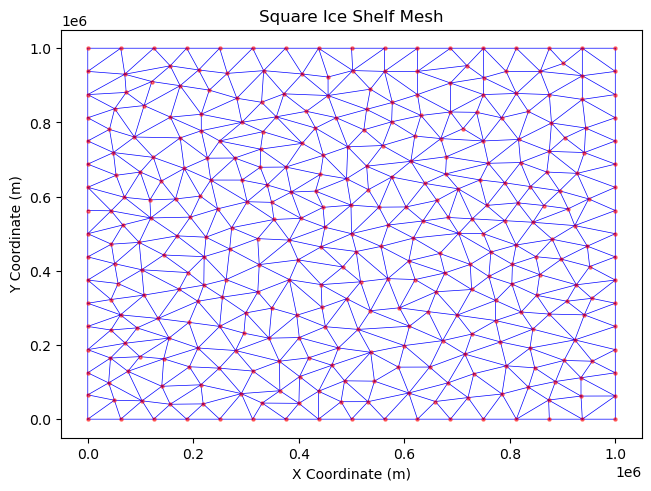

In [5]:
# Plot the mesh with customised options
fig, ax = pyissm.plot.plot_mesh2d(md,
                                  color = 'blue',
                                  linewidth = 0.5,
                                  show_nodes = True,
                                  node_kwargs = {'s': 20,
                                                 'color': 'red',
                                                 'alpha': 0.5})

# We can interact with the plot using stamdard matplotlib functions
ax.set_xlabel('X Coordinate (m)')
ax.set_ylabel('Y Coordinate (m)')
ax.set_title('Square Ice Shelf Mesh')

---
## 2. Model Mask

The `md.mask.ice_levelset` and `md.mask.ocean_levelset` fields interact to define where there is grounded ice, floating ice, ice-free regions, and open ocean within the model domain, as follows:

- `ice_levelset` < 0: Ice present
- `ice_levelset` = 0: Ice-front position
- `ice_levelset` > 0: No ice present
- `ocean_levelset` <0: Ocean present
- `ocean_levelset` = 0: Coastline / grounding line
- `ocean_levelset` > 0: No ocean present

In this example, the entire domain is floating ice. We can use the `set_mask()` function to efficiently define the `md.mask` fields.

After the mask is defined, all mask information is stored in the `md.mask` model sub-class. We can view the mask information by simply inspecting `md.mask`. Below, we can see that the `ice_levelset` and `ocean_levelset` fields have a size of `(340, 0)`, consistent with `md.mesh.numberofvertices` (i.e., these fiels are defined on the model vertices).

To ensure the mask is defined as we expect, we can visualise the `ice_levelset` and `ocean_levelset` fields. In addition, we can visualise how these fields interact within the model to confirm regions that are defined as "floating ice" in this example.


In [6]:
# Define the mask: all ice is floating
md = pyissm.model.param.set_mask(md,
                                 floating_ice_name = 'all',
                                 grounded_ice_name = None)

# Inspect the mask
md.mask

   mask parameters:
         ice_levelset           : (340,)          -- presence of ice if < 0, icefront position if = 0, no ice if > 0
         ocean_levelset         : (340,)          -- presence of ocean if < 0, coastline/grounding line if = 0, no ocean if > 0

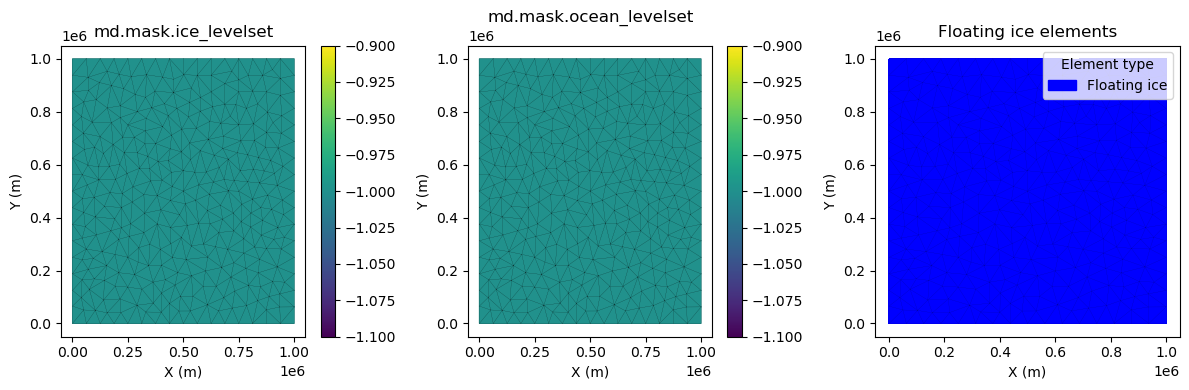

In [7]:
# Visuale the mask
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

## Visualise the `ice_levelset` field
pyissm.plot.plot_model_field(md,
                             md.mask.ice_levelset,
                             show_cbar = True,
                             show_mesh = True,
                             ax = ax1)
ax1.set_title('md.mask.ice_levelset')

## Visualise the `ocean_levelset` field
pyissm.plot.plot_model_field(md,
                             md.mask.ocean_levelset,
                             show_cbar = True,
                             show_mesh = True,
                             ax = ax2)
ax2.set_title('md.mask.ocean_levelset')

## Visualise "floating ice" elements
pyissm.plot.plot_model_elements(md,
                                ice_levelset = md.mask.ice_levelset,
                                ocean_levelset = md.mask.ocean_levelset,
                                type = 'floating_ice_elements',
                                show_mesh = True,
                                ax = ax3)
ax3.set_title('Floating ice elements')

plt.tight_layout()

We can see that the individual mask fields (i.e. `ice_levelset` and `ocean_levelset`) both have constant values of `-1`. As a result, the entire model domain is considered "floating ice". There is no grounded ice or open ocean within the model domain.

---
## 3. Parameterisation

Before we can execute a model, we must "parameterise" the model to define necessary components. This includes specifying model components such as ice geometry, initial conditions, friction representation, etc. 

```{warning}
**pyissm.model.param.parameterize()** 

In this example, we explicitly include the code used to parameterise the model. However, you might choose to move this parameterisation code to a secondary `*.py` file and use `pyissm.model.param.parameterize()` instead.

This functions **exactly** the same as running the code directly, but helps to keep your main model execution scripts clean.

### Define geometry

In this example, we use an idealised ice thickness that ranges from 300 to 1000 m. From this, we define an ice base (assuming hydrostatic equilibrium) and calculate an associated ice surface. All geometry information is stored in the `md.geometry` model sub-class. We can view the model geometry information by simply inspecting `md.geometry`.

We can visualise the model geometry fields using the `pyissm.plot.plot_model_field()` function.

In [8]:
# Define constants
hmin = 300
hmax = 1000
ymin = np.nanmin(md.mesh.y)
ymax = np.nanmax(md.mesh.y)

# Assign geometry to the model
md.geometry.thickness = hmax + (hmin - hmax) * (md.mesh.y - ymin) / (ymax - ymin)
md.geometry.base = - md.materials.rho_ice / md.materials.rho_water * md.geometry.thickness
md.geometry.surface = md.geometry.base + md.geometry.thickness

# Inspect the geometry
md.geometry

   geometry parameters:
         surface                : (340,)          -- ice upper surface elevation [m]
         thickness              : (340,)          -- ice thickness [m]
         base                   : (340,)          -- ice base elevation [m]
         bed                    : N/A             -- bed elevation [m]
         hydrostatic_ratio      : N/A             -- hydrostatic ratio for floating ice

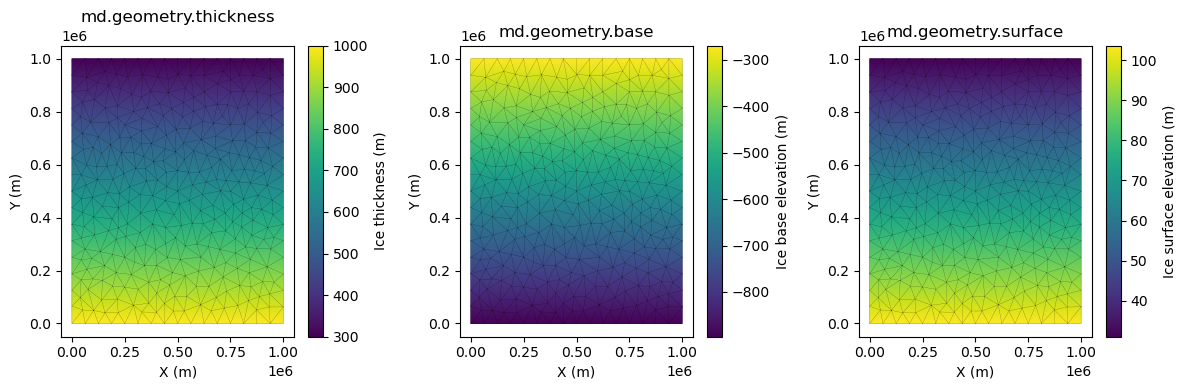

In [9]:
# Visualise the model geometry
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

## Ice thickness
pyissm.plot.plot_model_field(md,
                             md.geometry.thickness,
                             show_cbar = True,
                             show_mesh = True,
                             ax = ax1,
                             cbar_kwargs = {'label': 'Ice thickness (m)'})
ax1.set_title('md.geometry.thickness')

## Ice base
pyissm.plot.plot_model_field(md,
                             md.geometry.base,
                             show_cbar = True,
                             show_mesh = True,
                             ax = ax2,
                             cbar_kwargs = {'label': 'Ice base elevation (m)'})
ax2.set_title('md.geometry.base')

## Ice surface
pyissm.plot.plot_model_field(md,
                             md.geometry.surface,
                             show_cbar = True,
                             show_mesh = True,
                             ax = ax3,
                             cbar_kwargs = {'label': 'Ice surface elevation (m)'})
ax3.set_title('md.geometry.surface')

plt.tight_layout()

### Define friction

In this example, because all ice is floating, no basal friction is applied. Here, we can define a constant value of `0` to all friction fields. Note that ISSM requires that some friction fields are defined on vertices (e.g., `md.friction.coefficient`), while others are defined on elements (e.g., `md.friction.p`). The required size of each the field is checked by pyISSM before a model file is executed. All friction information is stored in the `md.friction` model sub-class. We can view the model friction information by simply inspecting `md.geometry`.

In [10]:
# Define friction parameters
md.friction.coefficient = np.zeros(md.mesh.numberofvertices, )
md.friction.p = np.zeros(md.mesh.numberofelements, )
md.friction.q = np.zeros(md.mesh.numberofelements, )

# Inspect friction parameters
md.friction

Basal shear stress parameters: Sigma_b = coefficient^2 * Neff ^r * |u_b|^(s - 1) * u_b,
(effective stress Neff = rho_ice * g * thickness + rho_water * g * base, r = q / p and s = 1 / p)
         coefficient            : (340,)          -- friction coefficient [SI]
         p                      : (614,)          -- p exponent
         q                      : (614,)          -- q exponent
         coupling               : 0               -- Coupling flag 0: uniform sheet (negative pressure ok, default), 1: ice pressure only, 2: water pressure assuming uniform sheet (no negative pressure), 3: use provided effective_pressure, 4: used coupled model (not implemented yet)
         linearize              : 0               -- 0: not linearized, 1: interpolated linearly, 2: constant per element (default is 0)
         effective_pressure     : N/A             -- Effective Pressure for the forcing if not coupled [Pa]
         effective_pressure_l...: 0               -- Neff do not allow to fall

### Define initial ice velocity

In this example, we define an initial velocity of `0` across the entire model domain. All initialization information is stored on the `md.initialization` model sub-class. We can view the model initialization information by simply inspecting `md.initialization`.

In [11]:
# Define initial velocities
md.initialization.vx = np.zeros(md.mesh.numberofvertices, )
md.initialization.vy = np.zeros(md.mesh.numberofvertices, )
md.initialization.vz = np.zeros(md.mesh.numberofvertices, )
md.initialization.vel = np.zeros(md.mesh.numberofvertices, )

# Inspect initialization fields
md.initialization

   initial field values:
         vx                     : (340,)          -- x component of velocity [m/yr]
         vy                     : (340,)          -- y component of velocity [m/yr]
         vz                     : (340,)          -- z component of velocity [m/yr]
         vel                    : (340,)          -- velocity norm [m/yr]
         pressure               : N/A             -- pressure [Pa]
         temperature            : N/A             -- temperature [K]
         enthalpy               : N/A             -- enthalpy [J]
         waterfraction          : N/A             -- fraction of water in the ice
         watercolumn            : N/A             -- thickness of subglacial water [m]
         sediment_head          : N/A             -- sediment water head of subglacial system [m]
         epl_head               : N/A             -- epl water head of subglacial system [m]
         epl_thickness          : N/A             -- thickness of the epl [m]
         

### Define flow law parameters

In this example, we assume all ice is -20 °C and compute ice regidity using the `pyissm.tools.materials.paterson()` parameterisation. Note that ISSM requires that some materials fields are defined on vertices (e.g., `md.materials.rheology_B`), while others are defined on elements (e.g., `md.materials.rheology_n`). The required size of each the field is checked by pyISSM before a model file is executed. All materials information is stored on the `md.materials` model sub-class. We can view the materials information by simply inspecting `md.materials`.


In [12]:
# Define materials parameters
md.materials.rheology_B = pyissm.tools.materials.paterson(273.15 - 20) * np.ones(md.mesh.numberofvertices, )
md.materials.rheology_n = 3 * np.ones(md.mesh.numberofelements, )

# Inspect the materials parameters
md.materials

   Materials (ice):
         rho_ice                : 917.0           -- ice density [kg/m^3]
         rho_water              : 1023.0          -- ocean water density [kg/m^3]
         rho_freshwater         : 1000.0          -- fresh water density [kg/m^3]
         mu_water               : 0.001787        -- water viscosity [N s/m^2]
         heatcapacity           : 2093.0          -- heat capacity [J/kg/K]
         thermalconductivity    : 2.4             -- ice thermal conductivity [W/m/K]
         temperateiceconducti...: 0.24            -- temperate ice thermal conductivity [W/m/K]
         meltingpoint           : 273.15          -- melting point of ice at 1atm in K
         latentheat             : 334000.0        -- latent heat of fusion [J/m^3]
         beta                   : 9.8e-08         -- rate of change of melting point with pressure [K/Pa]
         mixed_layer_capacity   : 3974.0          -- mixed layer capacity [W/kg/K]
         thermal_exchange_vel...: 0.0001      

---
## 4. Boundary conditions

In this example, we run a "Stress balance" solution to compute ice velocity in steady-state. When running a Stress Balance solution, ISSM assumes a stress-free boundary condition at the ice sheet surface and applies a viscous friction law at the base of the ice sheet. Water pressure is applied at the ice/water interface.

As a result, we define Neumann boundary conditions along the ice-front and Dirichlet boundary conditions on all inflow nodes. Stress balance boundary conditions are defined by combination of fields in `md.stressbalance.spcvx`, `md.stressbalance.spxvy` and `md.stressbalance.spcvz`. We can set these automatically using `pyissm.model.bc.set_ice_shelf_bc()` and providing an ARGUS `*.exp` file that defines the ice front position. Here, since no observed velocities have been added to the model, all stress balance model boundary conditions are set to `0`. All stressbalance information is stored on the `md.stressbalance` model sub-class. We can view the stressbalance information by simply inspecting `md.stressbalance`. 

We can visualse the model boundary conditions using `pyissm.plot.plot_model_bc(md)`.


In [13]:
# Set ice shelf boundary conditions.
md = pyissm.model.bc.set_ice_shelf_bc(md, asset_dir + '/Exp/SquareIceShelf_IceFront.exp')

# Inspect boundary conditions
# Stress balance boundary conditions are defined by combination of fields in md.stressbalance.spcvx, md.stressbalance.spcvy, md.stressbalance.spcvz.
md.stressbalance

/home/565/lb9857/gitRepos/pyISSM/src/pyissm/model/bc.py:102: UserWarning: pyissm.model.bc._set_sb_dirichlet_bc: No observed velocities found. Setting stressbalance model boundary conditions as 0.
  warnings.warn('pyissm.model.bc._set_sb_dirichlet_bc: No observed velocities found. Setting stressbalance model boundary conditions as 0.')
/home/565/lb9857/gitRepos/pyISSM/src/pyissm/model/classes/smb.py:114: UserWarning: pyissm.model.classes.smb.default: smb.mass_balance not specified -- set to 0.
  warnings.warn('pyissm.model.classes.smb.default: smb.mass_balance not specified -- set to 0.')
/home/565/lb9857/gitRepos/pyISSM/src/pyissm/model/classes/basalforcings.py:116: UserWarning: pyissm.model.classes.basalforcings.default: no groundedice_melting_rate specified -- values set as 0
  warnings.warn('pyissm.model.classes.basalforcings.default: no groundedice_melting_rate specified -- values set as 0')
/home/565/lb9857/gitRepos/pyISSM/src/pyissm/model/classes/basalforcings.py:120: UserWarning

   StressBalance solution parameters:
      Convergence criteria:
         restol                 : 0.0001          -- mechanical equilibrium residual convergence criterion
         reltol                 : 0.01            -- velocity relative convergence criterion, NaN: not applied
         abstol                 : 10              -- velocity absolute convergence criterion, NaN: not applied
         isnewton               : 0               -- 0: Picard's fixed point, 1: Newton's method, 2: hybrid
         maxiter                : 100             -- maximum number of nonlinear iterations

      boundary conditions:
         spcvx                  : (340,)          -- x-axis velocity constraint (NaN means no constraint) [m / yr]
         spcvy                  : (340,)          -- y-axis velocity constraint (NaN means no constraint) [m / yr]
         spcvz                  : (340,)          -- z-axis velocity constraint (NaN means no constraint) [m / yr]

      MOLHO boundary conditions

Text(0.5, 1.0, 'Square Ice Shelf Boundary Conditions')

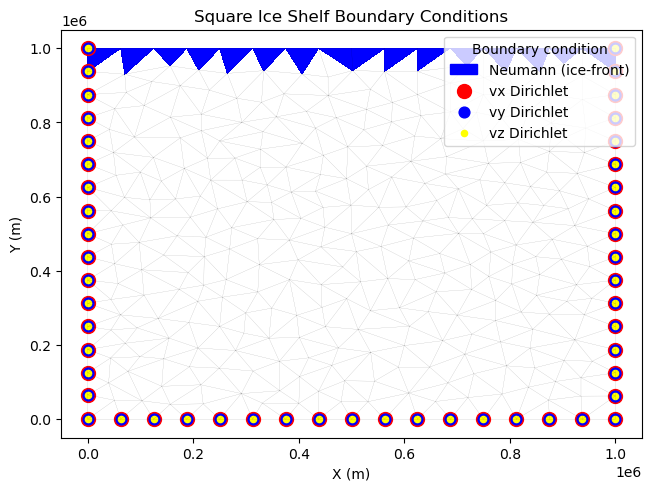

In [14]:
# Visualise boundary conditions
fig, ax = pyissm.plot.plot_model_bc(md)

ax.set_title('Square Ice Shelf Boundary Conditions')

---
## 5. Set the flow equation

This example uses the Shelfy-Stream Approximation (SSA) of the Full-Stokes equation across the whole domain. To define this, we can use `pyissm.model.param.set_flow_equation()`. All flow equation information is stored on the `md.flowequation` model sub-class. We can view the flowequation information by simply inspecting `md.flowequation`.  

In [15]:
# Use the SSA flow approximation across the whole domain
md = pyissm.model.param.set_flow_equation(md, SSA = 'all')

In [16]:
md.flowequation

   flow equation parameters:
         isSIA                  : 0               -- is the Shallow Ice Approximation (SIA) used?
         isSSA                  : 1               -- is the Shelfy-Stream Approximation (SSA) used?
         isL1L2                 : 0               -- are L1L2 equations used?
         isMOLHO                : 0               -- are MOno-layer Higher-Order (MOLHO) equations used?
         isHO                   : 0               -- is the Higher-Order (HO) approximation used?
         isFS                   : 0               -- are the Full-FS (FS) equations used?
         isNitscheBC            : 0               -- is weakly imposed condition used?
         FSNitscheGamma         : 1000000.0       -- Gamma value for the Nitsche term (default: 1e6)
         fe_SSA                 : 'P1'            -- Finite Element for SSA: 'P1', 'P1bubble' 'P1bubblecondensed' 'P2'
         fe_HO                  : 'P1'            -- Finite Element for HO:  'P1', 'P1bubble', 

---
## 6. Execute the model

To compute the velocity of the ice shelf, we use the "Stress Balance" solution. To run this example, we use the default `md.cluster` as this model is small enough to run on typical HPC login nodes, or directly on local machines.

Here, the results are loaded back onto `md.results` once the model run has finished.

In [17]:
md.cluster.executionpath = execution_dir
md.miscellaneous.name = 'SquareIceShelf'
md = pyissm.model.execute.solve(md, 'Stressbalance')

Checking model consistency...
Marshalling for SquareIceShelf.bin


/home/565/lb9857/gitRepos/pyISSM/src/pyissm/model/classes/qmu.py:95: UserWarning: pyissm.model.classes.qmu::qmu not yet implemented. Turning off qmu.
  warnings.warn('pyissm.model.classes.qmu::qmu not yet implemented. Turning off qmu.')


Uploading files to cluster...
Transferring SquareIceShelf-02-22-2026-14-25-33-1982518.tar.gz to cluster gadi-cpu-bdw-0001.gadi.nci.org.au...
Launching job SquareIceShelf on cluster gadi-cpu-bdw-0001.gadi.nci.org.au...

Ice-sheet and Sea-level System Model (ISSM) version  4.24
(GitHub: https://issmteam.github.io/ISSM-Documentation/ Documentation: https://github.com/ISSMteam/ISSM/)

call computational core:
   computing new velocity
write lock file:

   FemModel initialization elapsed time:   0.0226902
   Total Core solution elapsed time:       0.214713
   Linear solver elapsed time:             0.0610198 (28%)

   Total elapsed time: 0 hrs 0 min 0 sec
Waiting for job to complete...
wait_on_lock not implemented yet
Job completed -- loading results from cluster...
Retrieving results from cluster gadi-cpu-bdw-0001.gadi.nci.org.au...


---
## 7. Visualise model results

Once the model has finised executing, results are automatically loaded to `md.results`. We can view the model results by inspecting `md.results.StressbalanceSolution`. We can see that `md.results.StressbalanceSolution` contains 2D fields for `Vx`, `Vy`, `Vel`, and `Pressure`. The `steps` and `time` fields are both `0` since this was not a transient simulation.

To provide a summary of the solution, including all fields, and their associated data type and shape, we can use `pyissm.tools.general.summarize_solution()`.


We can visualise the computed ice velocity field using `pyissm.model.plot_model_field()`.

In [18]:
# View a summary of the model solution
pyissm.tools.general.summarize_solution(md.results.StressbalanceSolution)

Field                               Type                 Shape / Length
---------------------------------------------------------------------------
StressbalanceConvergenceNumSteps    ndarray              (1,)
step                                int32                scalar
time                                float64              scalar
Vx                                  ndarray              (340,)
Vy                                  ndarray              (340,)
Vel                                 ndarray              (340,)
Pressure                            ndarray              (340,)
SolutionType                        str                  scalar
errlog                              list                 len=0
outlog                              str                  scalar


Text(0.5, 1.0, 'Square Ice Shelf Velocity Field')

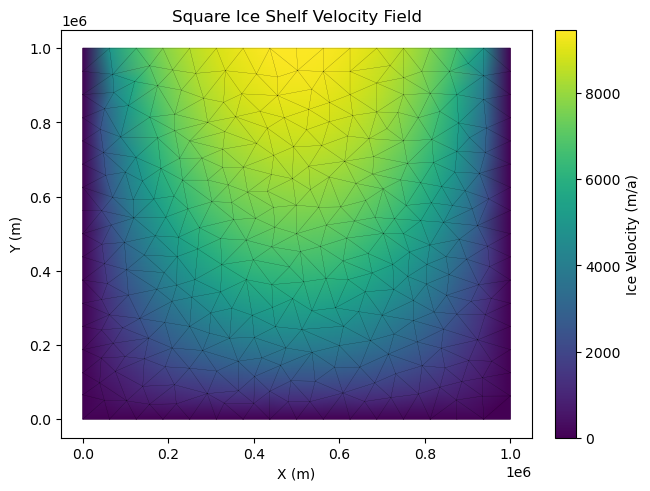

In [19]:
# Visualise the resultant velocity field
fig, ax = pyissm.plot.plot_model_field(md,
                                       field = md.results.StressbalanceSolution.Vel,
                                       show_cbar = True,
                                       cbar_kwargs={'label': 'Ice Velocity (m/a)'},
                                       show_mesh = True)
ax.set_title('Square Ice Shelf Velocity Field')

---
## 8. Save model

At any stage throughout the modelling process, we can save the current model state using `pyissm.model.io.save_model()`. Now we're all finished, let's save the model next to the tutorial notebook for a rainy day!

In [20]:
# Save model
pyissm.model.io.save_model(md, tutorial_dir + '/ex1_SquareIceShelf.nc')